# Análise do Dataset  
Agora que limpamos os dados é a hora de se aprofundar mais no dataset.

## Importando as Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Definições Auxiliares

In [2]:
# define colors
GRAY1, GRAY2, GRAY3 = '#231F20', '#414040', '#555655'
GRAY4, GRAY5, GRAY6 = '#646369', '#76787B', '#828282'
GRAY7, GRAY8, GRAY9 = '#929497', '#A6A6A5', '#BFBEBE'
BLUE1, BLUE2, BLUE3, BLUE4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
RED1, RED2 = '#C3514E', '#E6BAB7'
GREEN1, GREEN2 = '#0C8040', '#9ABB59'
ORANGE1 = '#F79747'


In [3]:
# configure plot font family to Arial
plt.rcParams['font.family'] = 'Arial'
# configure mathtext bold and italic font family to Arial
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'

%matplotlib inline

## Análise

In [4]:
df_vale = pd.read_csv('./dados/dados_limpos/vale_do_paraiba.csv', parse_dates=['date'])

In [5]:
df_vale.head()

,city,date,epidemiological_week,estimated_population,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths
0,São José dos Campos,2020-03-18,202012,729737.0,False,1,0.13704,2020-03-18,0.0,0,1,1,0
1,São José dos Campos,2020-03-19,202012,729737.0,True,1,0.13704,2020-03-18,0.0,0,2,0,0
2,Taubaté,2020-03-19,202012,317915.0,False,1,0.31455,2020-03-19,0.0,0,1,1,0
3,São José dos Campos,2020-03-20,202012,729737.0,False,1,0.13704,2020-03-20,0.0,0,3,0,0
4,Taubaté,2020-03-20,202012,317915.0,False,1,0.31455,2020-03-20,0.0,0,2,0,0


In [6]:
df_vale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20123 entries, 0 to 20122
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   city                                           20123 non-null  object        
 1   date                                           20123 non-null  datetime64[ns]
 2   epidemiological_week                           20123 non-null  int64         
 3   estimated_population                           20123 non-null  float64       
 4   is_repeated                                    20123 non-null  bool          
 5   last_available_confirmed                       20123 non-null  int64         
 6   last_available_confirmed_per_100k_inhabitants  20080 non-null  float64       
 7   last_available_date                            20123 non-null  object        
 8   last_available_death_rate                      20123 non

Antes de utilizamos a coluna se semana epidemiológica, precisamos realizar alguns ajustes nele. Isso porque, da maneira como ele está (tipo de dados int), quando plotarmos ele no eixo x vai imprimir semanas que não existem, como 2020-59 (2020 tiveram 53 semanas). Para evitar interpretações equivocadas vamos converter ele para o formato Y-U (ano-semana).

In [7]:
import datetime

def convert_column_to_year_week(serie : pd.Series):
    
    #converte a série para string, adicionando um '-W' antes do número da semana
    serie = (serie.apply(lambda x: str(x)[:4] + '-W' + str(x)[4:]))
    
    #converte a série gerada anteriormente para datetime.
    serie = serie.apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-W%W-%w'))
    
    #e finalmente, coloca a série no formato desejado, ano-semana.
    serie = (serie.apply(lambda x: datetime.datetime.strftime(x, '%Y-%U')))
    
    return serie
    

In [8]:
df_vale['epidemiological_week'] = convert_column_to_year_week(df_vale['epidemiological_week'])

Roteiro de investigação:
* Qual foi o primeiro caso registrado na região? E qual foi a última cidade a registrar o primeiro caso?
* Quais são as cidades com mais casos?
* Total de mortes por cidade
* As cidades com populações maiores teve mais casos proporcionalmente?
* Maior taxa de mortalidade
* Quais são as cidades que teve mais boletins?

### Qual foi o primeiro caso registrado na região? E qual foi a última cidade a registrar o primeiro caso?

In [9]:
df_primeiros_casos = df_vale[(df_vale['last_available_confirmed'] == 1) & 
                             (df_vale['is_repeated'] == False)]

df_primeiros_casos.groupby('city')[['date', 'epidemiological_week']].first(). \
                                                    reset_index().sort_values(by='date').head()

,city,date,epidemiological_week
31,São José dos Campos,2020-03-18,2020-12
33,Taubaté,2020-03-19,2020-12
4,Cachoeira Paulista,2020-03-31,2020-14
7,Caraguatatuba,2020-04-06,2020-15
21,Pindamonhangaba,2020-04-07,2020-15


A primeira cidade a registrar um caso foi São José dos Campos (18 de março de 2020) e a última cidade a registrar foi São José do Barreiro (1 de agosto de 2020).

### Quais são as cidades do Vale que teve mais casos?

In [10]:
df_total_casos_e_mortes = df_vale.groupby(['city'])['last_available_confirmed', 
                                                    'last_available_deaths'].last()


df_total_casos_e_mortes.reset_index(inplace=True)
df_total_casos_e_mortes.sort_values(by='last_available_confirmed', 
                                    ascending=False)[['city', 'last_available_confirmed']].head()

,city,last_available_confirmed
33,São José dos Campos,92113
36,Taubaté,28939
14,Jacareí,25245
7,Caraguatatuba,18074
22,Pindamonhangaba,15073


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


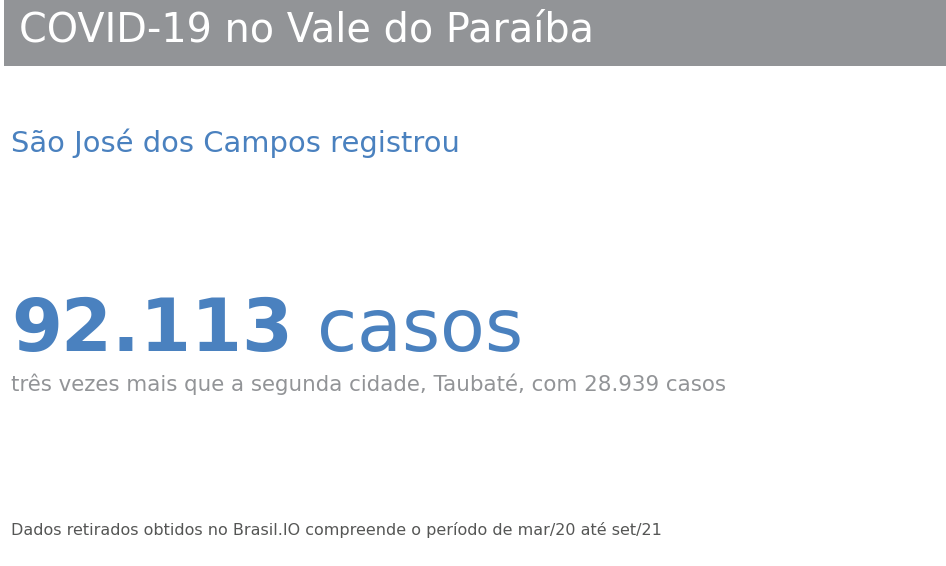

In [11]:
# create new figure
plt.figure(figsize=(10, 6), # width, height in inches
           dpi=110)         # resolution of the figure

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
# change the appearance of ticks, tick labels, and gridlines 
plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)


# titile the plot
plt.text(0.0099, 1.03,
         'COVID-19 no Vale do Paraíba'+' '*27,
         fontsize=26,
         color='white',
         bbox={'facecolor': GRAY7, 'pad': 10, 'edgecolor': 'none'}
         )

# footnote with the data source
plt.text(0, 0.04,
         'Dados retirados obtidos no Brasil.IO '
         'compreende o período de mar/20 até '
         'set/21',
         fontsize=10.5,
         color=GRAY3)

# add note to the plot
plt.text(0, 0.81,
         'São José dos Campos registrou',
         fontsize=19,
         color=BLUE2)

# add note to the plot
plt.text(0, 0.41,
         '$\\bf{92.113}$ casos', # use mathtext \\bf for bold text
         fontsize=48,
         color=BLUE2)


# add note to the plot
plt.text(0, 0.33,
         'três vezes mais que a segunda cidade, Taubaté, com 28.939 casos',
         fontsize=14,
         color=GRAY7)


plt.show()

### Quais são as cidades com mais mortes causados pela covid?

In [12]:
df_total_casos_e_mortes.sort_values(by='last_available_deaths', 
                                    ascending=False)[['city', 'last_available_deaths']].head()


,city,last_available_deaths
33,São José dos Campos,1931
36,Taubaté,910
14,Jacareí,756
7,Caraguatatuba,461
22,Pindamonhangaba,380


In [13]:
#Colocar aquele painel com o informativo

In [14]:
#Colocar total de casos

In [15]:
total_casos = df_total_casos_e_mortes['last_available_confirmed'].sum()
total_mortes = df_total_casos_e_mortes['last_available_deaths'].sum()

print(f'Total de casos no Vale do Paraíba: {total_casos: ,d}')
print(f'\nTotal de mortes: {total_mortes: ,d}')      

Total de casos no Vale do Paraíba:  266,486

Total de mortes:  6,320


Text(-0.15, 0.04, 'Dados retirados obtidos no Brasil.IO compreende o período de mar/20 até set/21')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


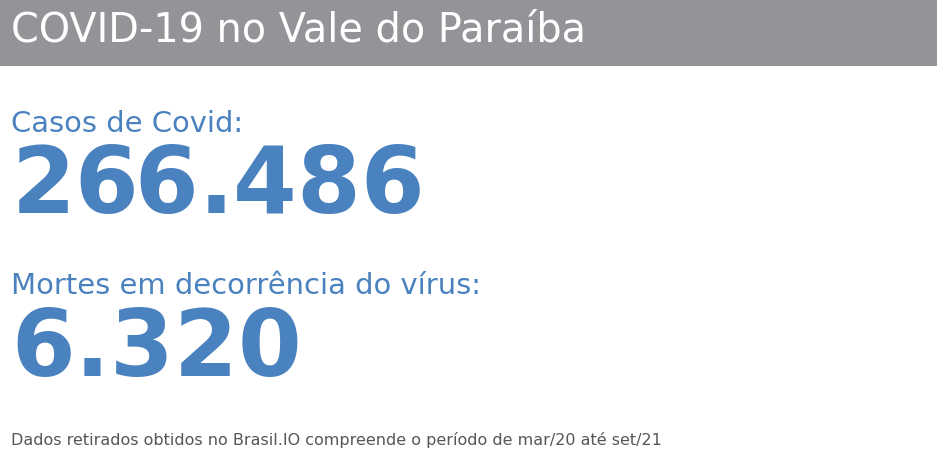

In [16]:
# create new figure
plt.figure(figsize=(7.45, 4.9), # width, height in inches
           dpi=110)             # resolution of the figure

# remove chart border
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# change the appearance of ticks, tick labels, and gridlines 
plt.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

# titile the plot
plt.text(-0.15, 1.03,
         'COVID-19 no Vale do Paraíba'+' '*27,
         fontsize=26,
         color='white',
         # put a rectangular box around the text to set a background color
         bbox={'facecolor': GRAY7, 'pad': 10, 'edgecolor': 'none'})

# add note to the plot
plt.text(-0.15, 0.81,
         'Casos de Covid:',
         fontsize=19,
         color=BLUE2)

# add note to the plot
plt.text(-0.15, 0.61,
         '$\\bf{266.486}$', # use mathtext \\bf for bold text
         fontsize=60,
         color=BLUE2)


# add note to the plot
plt.text(-0.15, 0.41,
         'Mortes em decorrência do vírus:',
         fontsize=19,
         color=BLUE2)

# add note to the plot
plt.text(-0.15, 0.21,
         '$\\bf{6.320}$', # use mathtext \\bf for bold text
         fontsize=60,
         color=BLUE2)


# footnote with the data source
plt.text(-0.15, 0.04,
         'Dados retirados obtidos no Brasil.IO '
         'compreende o período de mar/20 até '
         'set/21',
         fontsize=10.5,
         color=GRAY3)


### As cidades com populações maiores teve mais casos proporcionalmente?  
No dataset existe uma coluna que se chama `last_available_confirmed_per_100k_inhabitants` onde é calculado a proporção de casos a cada 100 mil habitantes. Vamos utilizar essa coluna para responder essa pergunta.


In [17]:
df_casos_proporcionais = df_vale.groupby('city').last()

df_casos_proporcionais.reset_index(inplace=True)
df_casos_proporcionais[['city', 'last_available_confirmed_per_100k_inhabitants']].\
                    sort_values(by='last_available_confirmed_per_100k_inhabitants', 
                                   ascending=False).head()

,city,last_available_confirmed_per_100k_inhabitants
12,Igaratá,22393.82239
13,Ilhabela,20819.87019
27,Roseira,15646.69938
7,Caraguatatuba,14647.98321
33,São José dos Campos,12622.76683


A primeira surpresa: a cidade com maior casos só aparece em quinto lugar.  
Vamos gerar a mesma tabela novamente, dessa vez com o número de casos e habitantes.

In [18]:
colunas_para_plotar = ['city', 'last_available_confirmed', 'estimated_population', 
                       'last_available_confirmed_per_100k_inhabitants']

df_casos_proporcionais[colunas_para_plotar].\
            sort_values(by='last_available_confirmed_per_100k_inhabitants', 
                        ascending=False).head(10)

,city,last_available_confirmed,estimated_population,last_available_confirmed_per_100k_inhabitants
12,Igaratá,2146,9583.0,22393.82239
13,Ilhabela,7410,35591.0,20819.87019
27,Roseira,1690,10801.0,15646.69938
7,Caraguatatuba,18074,123389.0,14647.98321
33,São José dos Campos,92113,729737.0,12622.76683
1,Arapeí,270,2460.0,10975.60976
5,Campos do Jordão,5680,52405.0,10838.66043
14,Jacareí,25245,235416.0,10723.57019
29,Santo Antônio do Pinhal,731,6827.0,10707.48499
3,Bananal,1133,10993.0,10306.55872


E aqui entendemos a importância dos valores relativos para comparar um dado. Vemos que, Igaratá tem 9.583 habitantes, e foram registrados 2146 casos de COVID-19 o que equivale à 22% da sua população. Sem a relativização dos dados, é impossível comparar os casos de cidades pequenas e cidades maiores, como é o caso de São José dos Campos, que teve um total de 12% da sua população infectada.  
O cálculo para chegar nesse resultado é:  
<br/>

$$ CasosPorCemMilHabitantes =  \frac{Casos Confirmados}{População Estimada}* 100.000 $$  

<br/>

Portanto, a cidade com maior casos proporcial à sua população é Igaratá. Vamos avaliar a evolução de casos confirmados, juntamente com mais três cidades com população semelhante.

In [19]:
cidades = ['Igaratá', 'Lavrinhas', 'Roseira', 'São Luiz do Paraitinga']

#Voltamos ao dataset df_vale, onde está a série temporal.
cidades_para_analise = df_vale[df_vale['city'].isin(cidades)]

cidades_para_analise.head()

,city,date,epidemiological_week,estimated_population,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,new_confirmed,new_deaths
128,Igaratá,2020-04-13,2020-16,9583.0,False,1,10.43515,2020-04-13,0.0,0,1,1,0
142,Igaratá,2020-04-14,2020-16,9583.0,False,1,10.43515,2020-04-14,0.0,0,2,0,0
157,Igaratá,2020-04-15,2020-16,9583.0,False,1,10.43515,2020-04-15,0.0,0,3,0,0
173,Igaratá,2020-04-16,2020-16,9583.0,False,1,10.43515,2020-04-16,0.0,0,4,0,0
189,Igaratá,2020-04-17,2020-16,9583.0,False,1,10.43515,2020-04-17,0.0,0,5,0,0


In [20]:
cidades = ['Igaratá (9583)', 'Lavrinhas (7311)', 
           'Roseira (10.801)', 'São Luiz do Paraitinga (10.690)']

In [21]:
list_color = ['red', 'forestgreen', 'steelblue', 'dimgrey']

igarata = cidades_para_analise[cidades_para_analise['city'] == 'Igaratá']\
                                        [['date', 'last_available_confirmed']]

lavrinhas = cidades_para_analise[cidades_para_analise['city'] == 'Lavrinhas']\
                                        [['date', 'last_available_confirmed']]

roseira = cidades_para_analise[cidades_para_analise['city'] == 'Roseira']\
                                        [['date', 'last_available_confirmed']]

sao_luiz = cidades_para_analise[cidades_para_analise['city'] == 'São Luiz do Paraitinga']\
                                        [['date', 'last_available_confirmed']]


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


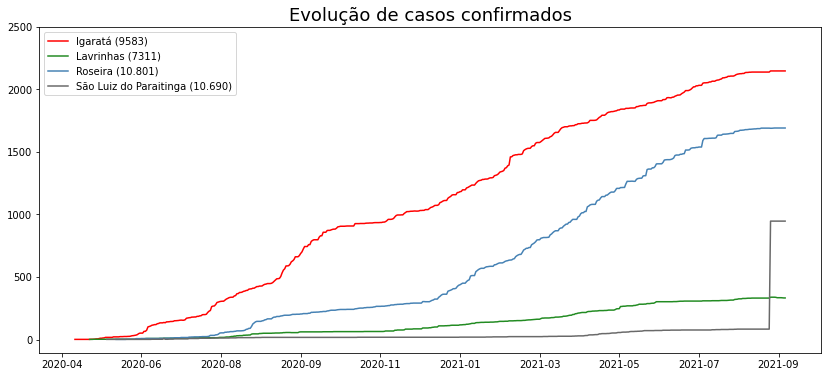

In [22]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(14, 6))
plt.title('Evolução de casos confirmados', fontsize=18)


plt.plot(igarata['date'], igarata['last_available_confirmed'], color = 'red')

plt.plot(lavrinhas['date'], lavrinhas['last_available_confirmed'], 
         color='forestgreen')

plt.plot(roseira['date'], roseira['last_available_confirmed'], color='steelblue')

plt.plot(sao_luiz['date'], sao_luiz['last_available_confirmed'], color='dimgrey')

ax.xaxis.set_major_locator(ticker.IndexLocator(base=60, offset=-10))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.yticks(np.arange(0, 2501, 500))
plt.legend(cidades)
plt.show()



Vemos que nenhuma das cidades com populações semelhantes teve a mesma proporção de casos. A partir de junho/20 os casos descolam das outras cidades.  
Outro ponto curioso é o fato de que os casos de São Luiz do Paraitinga aumentou verticalmente em setembro/21, o que pode indicar que os dados acumulados foram atualizados somente nessa época.

### Maior taxa de mortalidade

In [23]:
df_casos_proporcionais[['city', 'last_available_death_rate']]. \
            sort_values('last_available_death_rate', ascending=False)[:5]

,city,last_available_death_rate
16,Lagoinha,0.0508
23,Piquete,0.0504
20,Natividade da Serra,0.0461
0,Aparecida,0.0402
21,Paraibuna,0.0376


In [24]:
caso_full = pd.read_csv('./dados/dados_brutos/caso_full.csv')
caso_full_sp = caso_full.query('state=="SP"')

caso_full_sp['date'] = pd.to_datetime(caso_full_sp['date'], format='%Y-%m-%d')

caso_full_sp = caso_full_sp[caso_full_sp['date'] <= '2021-09-30']

caso_full_sp.query('city_ibge_code == 35.0')['last_available_death_rate'].tail(1)

333756    0.0343
Name: last_available_death_rate, dtype: float64

In [25]:
df_casos_proporcionais['last_available_death_rate'].mean()

0.023215384615384613

A cidade de Lagoinha mostrou uma maior taxa de mortalidade (mortos/casos confirmados) do vale do paraíba, com 5%. A fim de comparação, a média no Vale do Paraíba foi de 2%, enquanto para todo o estado foi de 3%.

### Quais são as cidades que teve mais boletins?  
Essa é uma questão interessante, pois conforme vimos no gráfico com maiores casos por cem mil habitantes, aquelas cidades teve um período considerável onde os casos não variaram. Isso foi por falta de notificação ou não houveram novos casos?  
Para tentarmos descobrir isso, vamos verificar a quantidade de boletim que cada cidade emitiu. podemos investigar a coluna `is_repeated`, que indica se a informação do registro é referente à data anterior ou original.

In [26]:
df_boletins = df_vale[df_vale['is_repeated'] == False]
df_boletins.groupby('city')[['order_for_place']].count().reset_index().\
                                    sort_values(by='order_for_place', ascending=False).head(10)

,city,order_for_place
36,Taubaté,514
33,São José dos Campos,514
35,São Sebastião,512
4,Cachoeira Paulista,508
28,Santa Branca,504
7,Caraguatatuba,502
22,Pindamonhangaba,501
8,Caçapava,500
14,Jacareí,500
11,Guaratinguetá,499


In [27]:
#Verificando a População
df_casos_proporcionais[['city', 'estimated_population']].sort_values('estimated_population', 
                                                                     ascending=False).head(10)

,city,estimated_population
33,São José dos Campos,729737.0
36,Taubaté,317915.0
14,Jacareí,235416.0
22,Pindamonhangaba,170132.0
7,Caraguatatuba,123389.0
11,Guaratinguetá,122505.0
8,Caçapava,95018.0
38,Ubatuba,91824.0
35,São Sebastião,90328.0
18,Lorena,89125.0


São José dos Campos e Taubaté, que possuem a maior população dentro da amostra, foram também os que mais emitiram boletins, e é possível verificar a relação entre o tamanho da população e a quantidade de boletins.

## Conclusão  
Os primeiros casos da COVID-19 no Vale do Paraíba aconteceram ainda em março de 2020, no começo da pandemia. Mesmo assim, por possuir poucas cidades metropolitanas a propagação foi lenta. Durante o período analisado (março/20 até setembro/21), a região teve mais de 266.486 casos e 6.320 vidas perdidas.  
Os principais pontos levantados durante a análise:
* O primeiro caso registrado no Vale do Paraíba aconteceu em São José dos Campos, em 18/03/2020;
* Em números absolutos, São José dos Campos também foi a cidade com maior quantidade de casos, totalizando mais de 92 mil casos - mais de 3 vezes mais que o segundo colocado, Taubaté;
    * Porém, ao avaliar os casos a cada 100 mil habitantes, São José cai para quinto lugar. O primeiro lugar fica com Igaratá.
* A cidade com mais mortes também foi São José dos campos - 1.931 óbitos;
* Os Dados sobre a taxa de mortalidade:
    * Taxa do estado de São Paulo: 3%;
    * Taxa do Vale do Paraíba: 2%;
    * Maior taxa entre as cidades: Lagoinha: 5%;
  
Diante do tamanho dos casos, no próximo notebook vamos criar um modelo para predizer os novos casos e óbitos da cidade de São José dos Campos.  
Um ponto que pude refletir ao analisar o dataset foi sobre a consistência dos dados. Realizar essa análise só foi possível graças ao esforço do Brasil.IO, que fez todo o trabalho de reunir, catalogar e disponibilidar os dados, tudo isso com esforço próprio. Mas como os dados são geradas pelas secretarias de saúdade de cada cidade, tudo depende da constância com a qual as informações são disponibilizadas. E vimos que nenhuma cidade emitiu boletins de forma diária. Sem mencionar os casos de subnotificação já conhecidas em todo o Brasil, mostra que não possuímos estrutura para acompanhar de forma mais acurada. 